In [1]:
print("starting...")
import torch

torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

starting...


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"
print(device)

mps


In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

In [4]:
color_chans = 1


class Encoder(nn.Module):
    kl = 0

    def __init__(self, latent_dims):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            # Initial processing
            nn.Conv2d(color_chans, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            # First downsample
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            # Second downsample
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResBlock(64),
            # Final processing
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # 64 channels * 7 * 7 spatial dimensions = 3136
        self.linear_mu = nn.Linear(64 * 7 * 7, latent_dims)
        self.linear_sigma = nn.Linear(64 * 7 * 7, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mu = self.linear_mu(x)
        linear_sigma_output = self.linear_sigma(x)

        if (
            torch.isnan(linear_sigma_output).any()
            or torch.isinf(linear_sigma_output).any()
        ):
            print("NaN or Inf detected in linear_sigma_output")

        sigma = torch.exp(self.linear_sigma(x))

        z = mu + sigma * self.N.sample(mu.shape)

        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1 / 2).mean()

        return z


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.decoder_input = nn.Linear(
            latent_dims, 64 * 7 * 7
        )  # Back to 64 channels * 7 * 7 spatial

        self.decoder = nn.Sequential(
            # Initial processing
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResBlock(64),
            # First upsample
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            # Second upsample
            nn.ConvTranspose2d(
                32, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResBlock(32),
            # Final processing
            nn.Conv2d(32, color_chans, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        # z: [B, latent_dims]
        z = self.decoder_input(z)
        # Reshape: [B, 3136] → [B, 64, 7, 7]
        z = z.view(z.size(0), 64, 7, 7)
        z = self.decoder(z)
        return z

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [10]:
from tqdm import tqdm


def train(autoencoder, data, epochs=20, lr=1e-3):
    print("starting training...")
    opt = torch.optim.AdamW(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(data, desc=f"Epoch {epoch}") as pbar:
            for x, y in pbar:
                x = x.to(device)
                opt.zero_grad()
                x_hat = autoencoder(x)

                recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")

                beta = 1000
                loss = recon_loss + autoencoder.encoder.kl * beta

                total_loss += loss.item()
                loss.backward()
                opt.step()

                pbar.set_postfix(loss=loss.item(), kl=autoencoder.encoder.kl.item())

        print(f"Loss: {total_loss / len(data)}")

    return autoencoder

In [19]:
latent_dims = 2
bs = 128
autoencoder = VariationalAutoencoder(latent_dims).to(device)

from sklearn.model_selection import train_test_split

mnist_data = torchvision.datasets.MNIST(
    "./data", transform=torchvision.transforms.ToTensor(), download=True
)

train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=False)

vae = VariationalAutoencoder(latent_dims).to(device)
vae = train(vae, train_loader, epochs=5, lr=1e-4)

starting training...


Loss: 28634.917161458332


Loss: 22703.839880208332


Loss: 22147.839390625


KeyboardInterrupt: 

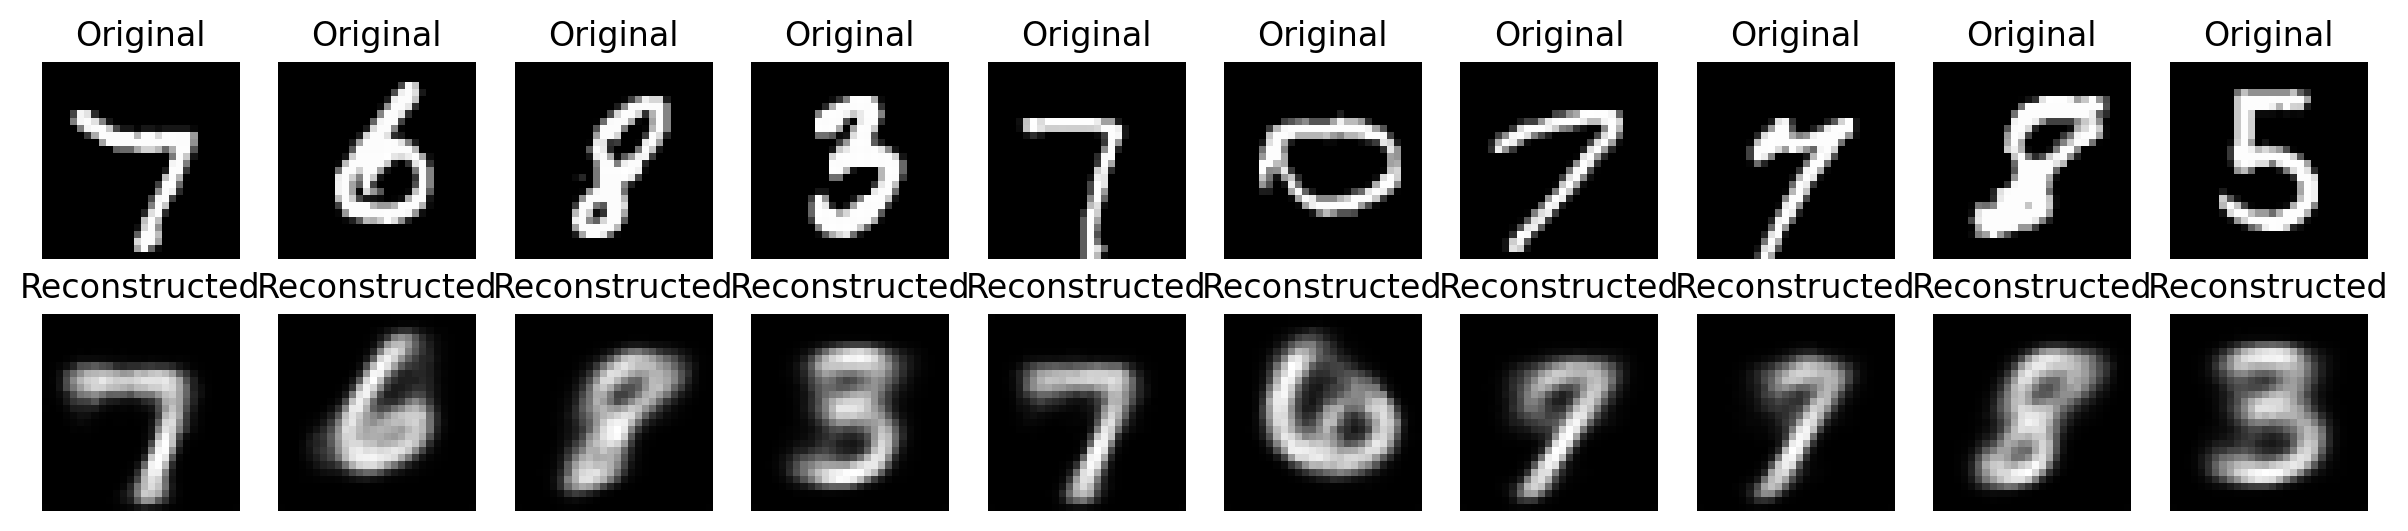

In [20]:
import matplotlib.pyplot as plt


def visualize_reconstruction(autoencoder, data, num_images=10):
    autoencoder.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
        for i, (x, _) in enumerate(data):
            if i >= num_images:
                break
            x = x.to(device)
            x_hat = autoencoder(x)
            x_hat = x_hat.to("cpu").numpy()
            x = x.to("cpu").numpy()

            axes[0, i].imshow(x[0].reshape(28, 28), cmap="gray")
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            axes[1, i].imshow(x_hat[0].reshape(28, 28), cmap="gray")
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis("off")

        plt.show()


visualize_reconstruction(vae, test_loader)


In [21]:
import ipywidgets as widgets
from IPython.display import display

print(latent_dims)

def interactive_plot(autoencoder, r0=(-5, 10), r1=(-10, 5)):
    def update(x=0.0, y=0.0):
        # Adjust the latent vector to match the expected dimensions
        z = torch.zeros((1, latent_dims)).to(device)
        z[0, :2] = torch.Tensor([x, y]).to(device)  # Assign x, y to the first two dimensions
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        plt.imshow(x_hat, extent=[*r0, *r1], cmap='gray')
        plt.axis('off')
        plt.show()

    x_slider = widgets.FloatSlider(value=0.0, min=r0[0], max=r0[1], step=0.05, description='X:')
    y_slider = widgets.FloatSlider(value=0.0, min=r1[0], max=r1[1], step=0.05, description='Y:')
    
    ui = widgets.VBox([x_slider, y_slider])
    out = widgets.interactive_output(update, {'x': x_slider, 'y': y_slider})
    
    display(ui, out)

interactive_plot(vae, r0=(-3, 3), r1=(-3, 3))


2


Output()

: 